In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Approach 1: TimeSeries approach groupby sales date -> merge with google data
(Assumption: Avocado King wants to see sale price per day )

## Load sales dataset

In [2]:
# Load dataset, groupby date and keep date, price, volume sales only
price_df = pd.read_csv('Data/price-and-sales-data.csv')

price_df = price_df[['Date', 'TotalVolume', '4046', '4225', '4770', 'AveragePrice']]
price_df.head()

,Date,TotalVolume,4046,4225,4770,AveragePrice
0,2015-01-04,40873.28,2819.50,28287.42,49.90,1.22
1,2015-01-04,435021.49,364302.39,23821.16,82.15,1.00
2,2015-01-04,788025.06,53987.31,552906.04,39995.03,NaN
3,2015-01-04,80034.32,44562.12,24964.23,2752.35,1.01
4,2015-01-04,491738.00,7193.87,396752.18,128.82,1.02


In [3]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25161 entries, 0 to 25160
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          25161 non-null  object 
 1   TotalVolume   24212 non-null  float64
 2   4046          24261 non-null  float64
 3   4225          24255 non-null  float64
 4   4770          24245 non-null  float64
 5   AveragePrice  24259 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.2+ MB


In [4]:
price_df.isna().sum()

Date              0
TotalVolume     949
4046            900
4225            906
4770            916
AveragePrice    902
dtype: int64

## Handle missing values with median
(one practice since only numeric columns selected)

In [5]:
price_df.fillna(price_df.median(), inplace=True)

<ipython-input-5-9a2617e11783>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  price_df.fillna(price_df.median(), inplace=True)


In [6]:
price_df.isna().sum()

Date            0
TotalVolume     0
4046            0
4225            0
4770            0
AveragePrice    0
dtype: int64

In [7]:
price_df['Date'] = pd.to_datetime(price_df['Date'])

## Group by date

In [8]:
weekly_sales = price_df.groupby('Date').mean()

In [9]:
weekly_sales.head(20)

,TotalVolume,4046,4225,4770,AveragePrice
Date,,,,,
2015-01-04,7.715821e+05,301867.474722,334851.406111,20896.305185,1.313148
2015-01-11,6.435016e+05,286426.126574,283050.260833,21621.077500,1.368056
2015-01-18,7.189948e+05,294857.126667,268240.774259,19042.178519,1.386667
2015-01-25,6.645113e+05,254303.940741,266998.711667,19247.836852,1.391389
2015-02-01,1.106550e+06,460072.465556,459061.778241,34146.070833,1.253796
2015-02-08,8.037530e+05,325367.033981,337618.885648,17586.882593,1.310185
2015-02-15,6.997478e+05,287944.188981,241041.746296,20831.407500,1.396667
2015-02-22,4.727916e+05,314457.565278,279423.783056,18573.232315,1.350000
2015-03-01,7.970134e+05,300914.576944,341758.219352,26392.295648,1.315093


<AxesSubplot:xlabel='Date'>

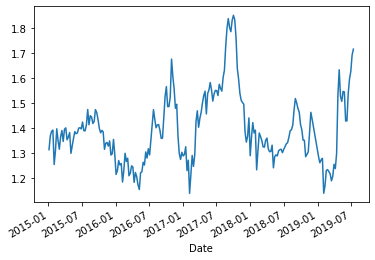

In [10]:
weekly_sales['AveragePrice'].plot()

In [11]:
google_data = pd.read_csv('Data/google-data.csv')
google_data['Week'] = pd.to_datetime(google_data['Week'])
google_data.head(20)

,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,2015-01-04,46,76,84,8,51,10
1,2015-01-11,48,79,76,8,38,29
2,2015-01-18,48,82,84,9,66,27
3,2015-01-25,49,82,89,8,44,28
4,2015-02-01,52,81,82,7,46,42
5,2015-02-08,41,80,67,8,60,40
6,2015-02-15,40,80,61,7,48,17
7,2015-02-22,41,82,55,8,50,23
8,2015-03-01,44,83,72,9,38,26
9,2015-03-08,41,80,66,7,47,31


## Merge with Google data

In [25]:
combined_df = pd.merge(weekly_sales, google_data, how='outer', left_on='Date', right_on='Week')
combined_df.head(20)

,TotalVolume,4046,4225,4770,AveragePrice,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,7.715821e+05,301867.474722,334851.406111,20896.305185,1.313148,2015-01-04,46.0,76.0,84.0,8.0,51.0,10.0
1,6.435016e+05,286426.126574,283050.260833,21621.077500,1.368056,2015-01-11,48.0,79.0,76.0,8.0,38.0,29.0
2,7.189948e+05,294857.126667,268240.774259,19042.178519,1.386667,2015-01-18,48.0,82.0,84.0,9.0,66.0,27.0
3,6.645113e+05,254303.940741,266998.711667,19247.836852,1.391389,2015-01-25,49.0,82.0,89.0,8.0,44.0,28.0
4,1.106550e+06,460072.465556,459061.778241,34146.070833,1.253796,2015-02-01,52.0,81.0,82.0,7.0,46.0,42.0
5,8.037530e+05,325367.033981,337618.885648,17586.882593,1.310185,2015-02-08,41.0,80.0,67.0,8.0,60.0,40.0
6,6.997478e+05,287944.188981,241041.746296,20831.407500,1.396667,2015-02-15,40.0,80.0,61.0,7.0,48.0,17.0
7,4.727916e+05,314457.565278,279423.783056,18573.232315,1.350000,2015-02-22,41.0,82.0,55.0,8.0,50.0,23.0
8,7.970134e+05,300914.576944,341758.219352,26392.295648,1.315093,2015-03-01,44.0,83.0,72.0,9.0,38.0,26.0
9,6.759716e+05,311544.367130,250239.511204,20653.669537,1.364815,2015-03-08,41.0,80.0,66.0,7.0,47.0,31.0


## Reason missing values with merged data

In [26]:
combined_df.isnull().sum()

TotalVolume                          7
4046                                 7
4225                                 7
4770                                 7
AveragePrice                         7
Week                                 1
avocado: (United States)             1
organic: (United States)             1
avocado recipe: (United States)      1
avocado toast: (United States)       1
avocado sandwich: (United States)    1
organic avocado: (United States)     1
dtype: int64

In [27]:
combined_df[combined_df.isnull().any(axis=1)]

,TotalVolume,4046,4225,4770,AveragePrice,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
205,1.137379e+06,348652.532407,303622.763148,21984.832222,1.281111,NaT,NaN,NaN,NaN,NaN,NaN,NaN
233,NaN,NaN,NaN,NaN,NaN,2018-12-09,43.0,81.0,50.0,35.0,44.0,34.0
234,NaN,NaN,NaN,NaN,NaN,2018-12-16,43.0,73.0,60.0,37.0,34.0,12.0
235,NaN,NaN,NaN,NaN,NaN,2018-12-23,50.0,63.0,55.0,42.0,27.0,56.0
236,NaN,NaN,NaN,NaN,NaN,2018-12-30,63.0,74.0,81.0,64.0,54.0,43.0
237,NaN,NaN,NaN,NaN,NaN,2019-01-06,73.0,85.0,88.0,68.0,61.0,67.0
238,NaN,NaN,NaN,NaN,NaN,2019-07-21,60.0,74.0,68.0,56.0,54.0,49.0
239,NaN,NaN,NaN,NaN,NaN,2019-07-28,66.0,74.0,79.0,55.0,46.0,36.0


In [28]:
combined_df.dropna(inplace=True)

## Feature selection based on correlation

<AxesSubplot:>

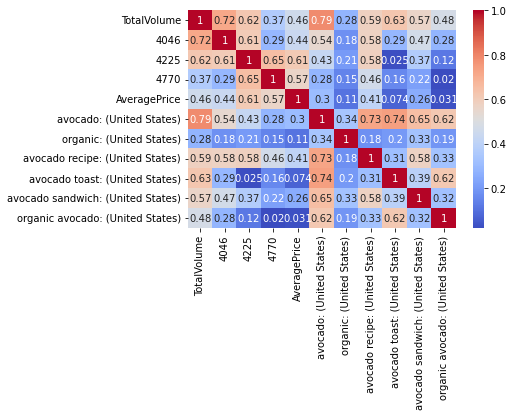

In [29]:
import numpy as np
sns.heatmap(np.abs(combined_df.corr()),annot=True, cmap='coolwarm')

In [30]:
a = np.abs(combined_df.corr())['AveragePrice'] > 0.3
column_df = pd.DataFrame(a)
keep_cols = list(column_df[column_df.AveragePrice==True].index.values)


In [31]:
keep_cols

['TotalVolume',
 '4046',
 '4225',
 '4770',
 'AveragePrice',
 'avocado: (United States)',
 'avocado recipe: (United States)']

In [32]:
combined_df

,TotalVolume,4046,4225,4770,AveragePrice,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,7.715821e+05,301867.474722,334851.406111,20896.305185,1.313148,2015-01-04,46.0,76.0,84.0,8.0,51.0,10.0
1,6.435016e+05,286426.126574,283050.260833,21621.077500,1.368056,2015-01-11,48.0,79.0,76.0,8.0,38.0,29.0
2,7.189948e+05,294857.126667,268240.774259,19042.178519,1.386667,2015-01-18,48.0,82.0,84.0,9.0,66.0,27.0
3,6.645113e+05,254303.940741,266998.711667,19247.836852,1.391389,2015-01-25,49.0,82.0,89.0,8.0,44.0,28.0
4,1.106550e+06,460072.465556,459061.778241,34146.070833,1.253796,2015-02-01,52.0,81.0,82.0,7.0,46.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...
228,9.956377e+05,261947.877870,263377.206759,20565.444074,1.538333,2019-06-16,59.0,80.0,70.0,51.0,56.0,41.0
229,9.720420e+05,253976.765463,253771.379259,19134.855648,1.596481,2019-06-23,57.0,79.0,71.0,53.0,45.0,56.0
230,9.649816e+05,235572.336389,263851.707963,21328.205833,1.626574,2019-06-30,61.0,73.0,80.0,52.0,62.0,35.0
231,9.841152e+05,244258.998519,286482.041019,25130.900926,1.691296,2019-07-07,58.0,76.0,66.0,55.0,51.0,42.0


## Model training

### Train test split

In [73]:
def train_test_split(input_df, test_start=2019, index_col='Week', output_col='AveragePrice', keep_cols=None):    
    set_df = input_df.set_index(index_col)
    if keep_cols:
        set_df = set_df[keep_cols]

    X = set_df.drop([output_col], axis=1)
    y = set_df[output_col]

    X_train = X[:str(test_start-1)]
    y_train = y[:str(test_start-1)]
    y_test = y[str(test_start):]
    X_test = X[str(test_start):]    
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(combined_df, test_start=2017, keep_cols=None)

### Scaler

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_Xtrain = scaler.fit_transform(X_train)
scaled_Xtest = scaler.transform(X_test)

<AxesSubplot:xlabel='Week'>

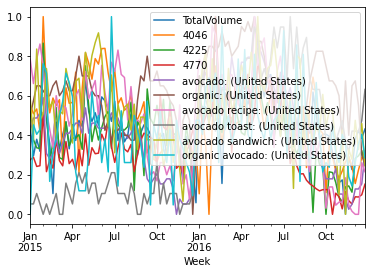

In [75]:
scaled_Xtrain_df = pd.DataFrame(scaled_Xtrain)
scaled_Xtrain_df.index = X_train.index
scaled_Xtrain_df.columns = X_train.columns
scaled_Xtrain_df.plot()

### Linear Regression model

-5.27868461228212


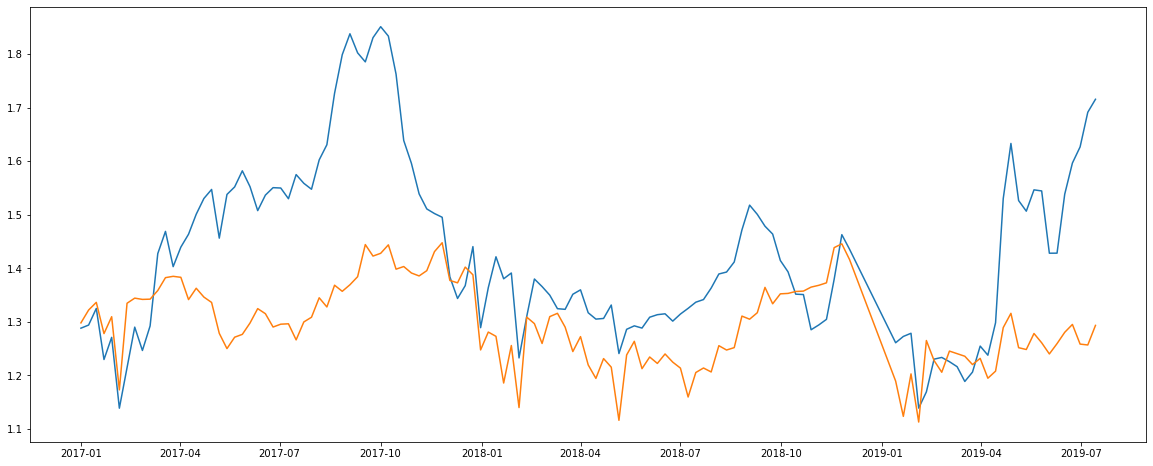

In [76]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(scaled_Xtrain, y_train)
y_predicted = lr.predict(scaled_Xtest)
print(r2_score(y_predicted, y_test.values))
y_predicted_df = pd.DataFrame(y_predicted)
y_predicted_df.index = y_test.index
plt.figure(figsize=(20,8))
plt.plot(y_test)
plt.plot(y_predicted_df)

### Ridge modelling

0.001 -5.279422322637458
0.01 -5.286105104233866
0.1 -5.356201540037285
100.0 -143.4188142558277
1000.0 -9678.68011898375
10000.0 -927602.7835665281
100000.0 -92364071.24918729
1000000.0 -9232451507.357447


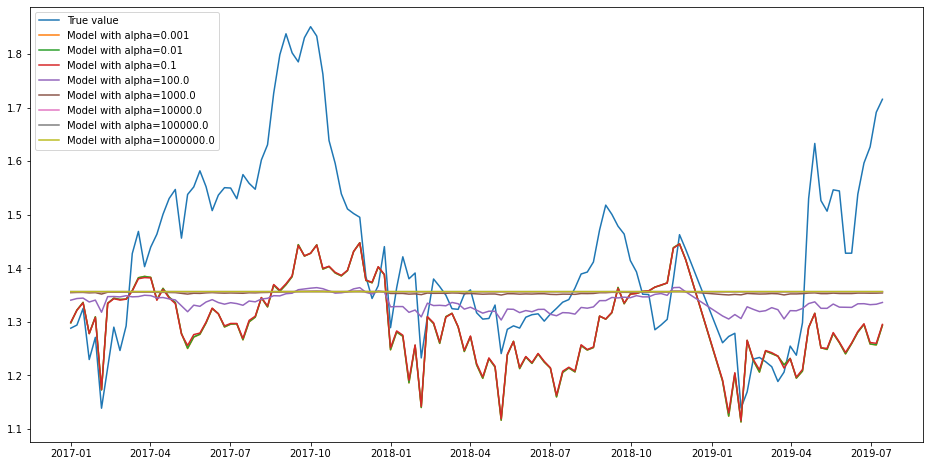

In [77]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
alphas = [1e-3, 1e-2, .1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.figure(figsize=(16,8))
plt.plot(y_test)
labels = ['True value']
for (ii, alpha) in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(scaled_Xtrain, y_train)
    y_predicted = model.predict(scaled_Xtest)
    y_predicted_df = pd.DataFrame(y_predicted)
    y_predicted_df.index = y_test.index
    print(alpha, r2_score(y_predicted, y_test.values))
    plt.plot(y_predicted_df)
    labels.append('Model with alpha='+str(alpha))

plt.legend(labels)

### Conclusion
Good for recognising the trend but not really predict the exact price.

# Approach 2: Tabular approach

In [115]:
price_df = pd.read_csv('Data/price-and-sales-data.csv')
price_df.head(100)

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,2015-01-04,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015-01-04,1.23,19089.36,17522.46,735.22,2.87,828.81,828.81,0.00,0.0,organic,2015,SanDiego
96,2015-01-04,1.18,22630.58,13175.57,9028.34,0.00,426.67,426.67,0.00,0.0,organic,2015,SanFrancisco
97,2015-01-04,1.49,33795.91,6821.76,20720.77,NaN,6252.15,452.73,5799.42,0.0,organic,2015,Seattle
98,2015-01-04,1.86,3351.76,355.79,754.78,439.19,1802.00,1768.67,NaN,0.0,organic,2015,SouthCarolina


In [116]:
print(price_df.describe())
print(price_df.info())

       AveragePrice   TotalVolume          4046          4225          4770  \
count  24259.000000  2.421200e+04  2.426100e+04  2.425500e+04  2.424500e+04   
mean       1.396018  9.170913e+05  2.981530e+05  2.958284e+05  2.246362e+04   
std        0.384476  3.731937e+06  1.288583e+06  1.209445e+06  1.046621e+05   
min        0.440000  8.456000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%        1.110000  1.323404e+04  8.225900e+02  3.061135e+03  0.000000e+00   
50%        1.360000  1.190528e+05  9.855110e+03  2.697755e+04  1.937600e+02   
75%        1.640000  4.733783e+05  1.141219e+05  1.498719e+05  6.078170e+03   
max        3.250000  6.371614e+07  2.274362e+07  2.047057e+07  2.546439e+06   

          TotalBags     SmallBags     LargeBags     XLargeBags          year  
count  2.427100e+04  2.422700e+04  2.421400e+04   24293.000000  25161.000000  
mean   2.950432e+05  2.124199e+05  7.589924e+04    4405.638467   2016.776877  
std    1.232967e+06  8.693043e+05  3.586079e+05   2

## Filling missing values with mean date average

In [117]:
checking_missing_values = price_df.isnull().any() == True
missing_value_cols = checking_missing_values[checking_missing_values == True].index.values
missing_value_cols

array(['AveragePrice', 'TotalVolume', '4046', '4225', '4770', 'TotalBags',
       'SmallBags', 'LargeBags', 'XLargeBags'], dtype=object)

In [118]:
for col in missing_value_cols:
    if price_df[col].dtypes != 'object':
        price_df[col] = price_df.groupby('Date')[col].transform(lambda x : x.fillna(x.mean()))

In [119]:
price_df.isnull().sum()

Date            0
AveragePrice    0
TotalVolume     0
4046            0
4225            0
4770            0
TotalBags       0
SmallBags       0
LargeBags       0
XLargeBags      0
type            0
year            0
region          0
dtype: int64

In [120]:
print(price_df.describe())
print(price_df.info())

       AveragePrice   TotalVolume          4046          4225          4770  \
count  25161.000000  2.516100e+04  2.516100e+04  2.516100e+04  2.516100e+04   
mean       1.396003  9.148542e+05  2.979322e+05  2.957121e+05  2.247366e+04   
std        0.378586  3.661058e+06  1.265392e+06  1.187539e+06  1.027607e+05   
min        0.440000  8.456000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%        1.120000  1.400096e+04  9.223600e+02  3.284480e+03  0.000000e+00   
50%        1.360000  1.363315e+05  1.225826e+04  3.093655e+04  2.520000e+02   
75%        1.630000  5.593169e+05  1.356466e+05  1.881154e+05  7.958550e+03   
max        3.250000  6.371614e+07  2.274362e+07  2.047057e+07  2.546439e+06   

          TotalBags     SmallBags     LargeBags     XLargeBags          year  
count  2.516100e+04  2.516100e+04  2.516100e+04   25161.000000  25161.000000  
mean   2.932332e+05  2.110326e+05  7.511472e+04    4361.059074   2016.776877  
std    1.211114e+06  8.531225e+05  3.518528e+05   2

## Merge with Google data

In [121]:
google_data = pd.read_csv('Data/google-data.csv')
google_data.head(10)

,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,2015-01-04,46,76,84,8,51,10
1,2015-01-11,48,79,76,8,38,29
2,2015-01-18,48,82,84,9,66,27
3,2015-01-25,49,82,89,8,44,28
4,2015-02-01,52,81,82,7,46,42
5,2015-02-08,41,80,67,8,60,40
6,2015-02-15,40,80,61,7,48,17
7,2015-02-22,41,82,55,8,50,23
8,2015-03-01,44,83,72,9,38,26
9,2015-03-08,41,80,66,7,47,31


In [125]:
combined_df = pd.merge(price_df, google_data, how='inner', left_on='Date', right_on='Week')
combined_df.head(100)

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,Week,avocado: (United States),organic: (United States),avocado recipe: (United States),avocado toast: (United States),avocado sandwich: (United States),organic avocado: (United States)
0,2015-01-04,1.220000,40873.28,2819.50,28287.42,49.900000,9716.46,9186.93,529.530000,0.0,conventional,2015,Albany,2015-01-04,46,76,84,8,51,10
1,2015-01-04,1.000000,435021.49,364302.39,23821.16,82.150000,46815.79,16707.15,30108.640000,0.0,conventional,2015,Atlanta,2015-01-04,46,76,84,8,51,10
2,2015-01-04,1.307835,788025.06,53987.31,552906.04,39995.030000,141136.68,137146.07,3990.610000,0.0,conventional,2015,BaltimoreWashington,2015-01-04,46,76,84,8,51,10
3,2015-01-04,1.010000,80034.32,44562.12,24964.23,2752.350000,7755.62,6064.30,1691.320000,0.0,conventional,2015,Boise,2015-01-04,46,76,84,8,51,10
4,2015-01-04,1.020000,491738.00,7193.87,396752.18,128.820000,87663.13,87406.84,256.290000,0.0,conventional,2015,Boston,2015-01-04,46,76,84,8,51,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015-01-04,1.230000,19089.36,17522.46,735.22,2.870000,828.81,828.81,0.000000,0.0,organic,2015,SanDiego,2015-01-04,46,76,84,8,51,10
96,2015-01-04,1.180000,22630.58,13175.57,9028.34,0.000000,426.67,426.67,0.000000,0.0,organic,2015,SanFrancisco,2015-01-04,46,76,84,8,51,10
97,2015-01-04,1.490000,33795.91,6821.76,20720.77,22114.101961,6252.15,452.73,5799.420000,0.0,organic,2015,Seattle,2015-01-04,46,76,84,8,51,10
98,2015-01-04,1.860000,3351.76,355.79,754.78,439.190000,1802.00,1768.67,24117.389216,0.0,organic,2015,SouthCarolina,2015-01-04,46,76,84,8,51,10


In [131]:
combined_df['AveragePrice'].dtypes

dtype('float64')

In [126]:
combined_df.isnull().sum()

Date                                 0
AveragePrice                         0
TotalVolume                          0
4046                                 0
4225                                 0
4770                                 0
TotalBags                            0
SmallBags                            0
LargeBags                            0
XLargeBags                           0
type                                 0
year                                 0
region                               0
Week                                 0
avocado: (United States)             0
organic: (United States)             0
avocado recipe: (United States)      0
avocado toast: (United States)       0
avocado sandwich: (United States)    0
organic avocado: (United States)     0
dtype: int64

## Convert non numeric to numeric (bad practice, I know)


In [132]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in combined_df.columns:
    if combined_df[col].dtypes == 'object':
        combined_df[col] = le.fit_transform(combined_df[col])      

## Correlation analysis

<AxesSubplot:>

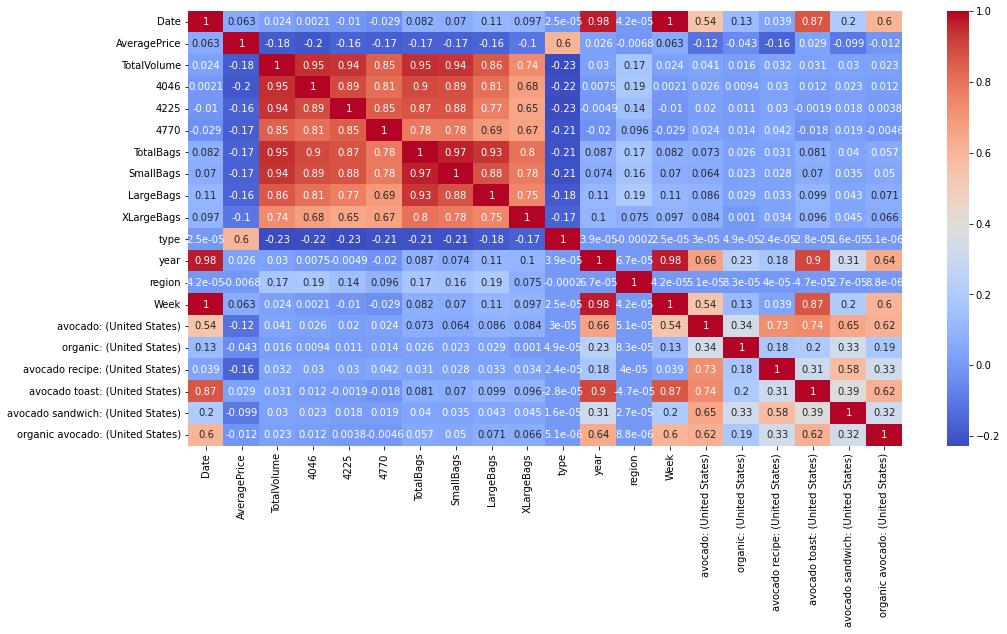

In [133]:
plt.figure(figsize=(16,8))
sns.heatmap(combined_df.corr(), cmap='coolwarm', annot=True)

In [134]:
X = combined_df.drop(['Date', 'AveragePrice'], axis=1)
y = combined_df['AveragePrice']

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaling

In [195]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaledX_train = scaler.fit_transform(X_train)
scaledX_test = scaler.transform(X_test)

## Dense ANN modeling

In [196]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [197]:
from tensorflow.keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def build_model(train_shape, optimizer='Adam', num_layers=1, num_perceptrons=10, activation='sigmoid'):
    model = Sequential()
    model.add(Input(shape=train_shape))
    for i in range(num_layers):
        model.add(Dense(num_perceptrons, activation=activation))
    model.add(Dense(1, activation='linear'))

    print(model.summary())
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae', coeff_determination])

    return model

model = build_model(scaledX_train.shape[1])




Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10)                190       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 11        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
None


In [198]:
model.fit(scaledX_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
549/549 [==============================] - 0s 590us/step - loss: 0.6230 - mse: 0.6230 - mae: 0.5822 - coeff_determination: -605.2429
Epoch 2/50
549/549 [==============================] - 0s 537us/step - loss: 0.1200 - mse: 0.1200 - mae: 0.2691 - coeff_determination: -0.6125
Epoch 3/50
549/549 [==============================] - 0s 546us/step - loss: 0.1002 - mse: 0.1002 - mae: 0.2451 - coeff_determination: -1023.4752
Epoch 4/50
549/549 [==============================] - 0s 588us/step - loss: 0.0910 - mse: 0.0910 - mae: 0.2331 - coeff_determination: -8173.0107
Epoch 5/50
549/549 [==============================] - 0s 564us/step - loss: 0.0874 - mse: 0.0874 - mae: 0.2286 - coeff_determination: -1035.4988
Epoch 6/50
549/549 [==============================] - 0s 583us/step - loss: 0.0858 - mse: 0.0858 - mae: 0.2262 - coeff_determination: -4223.4360
Epoch 7/50
549/549 [==============================] - 0s 569us/step - loss: 0.0850 - mse: 0.0850 - mae: 0.2249 - coeff_determination: 

In [200]:
from sklearn.metrics import mean_squared_error
y_predicted = model.predict(scaledX_test)
print(mean_squared_error(y_predicted, y_test))

0.07916730181963379


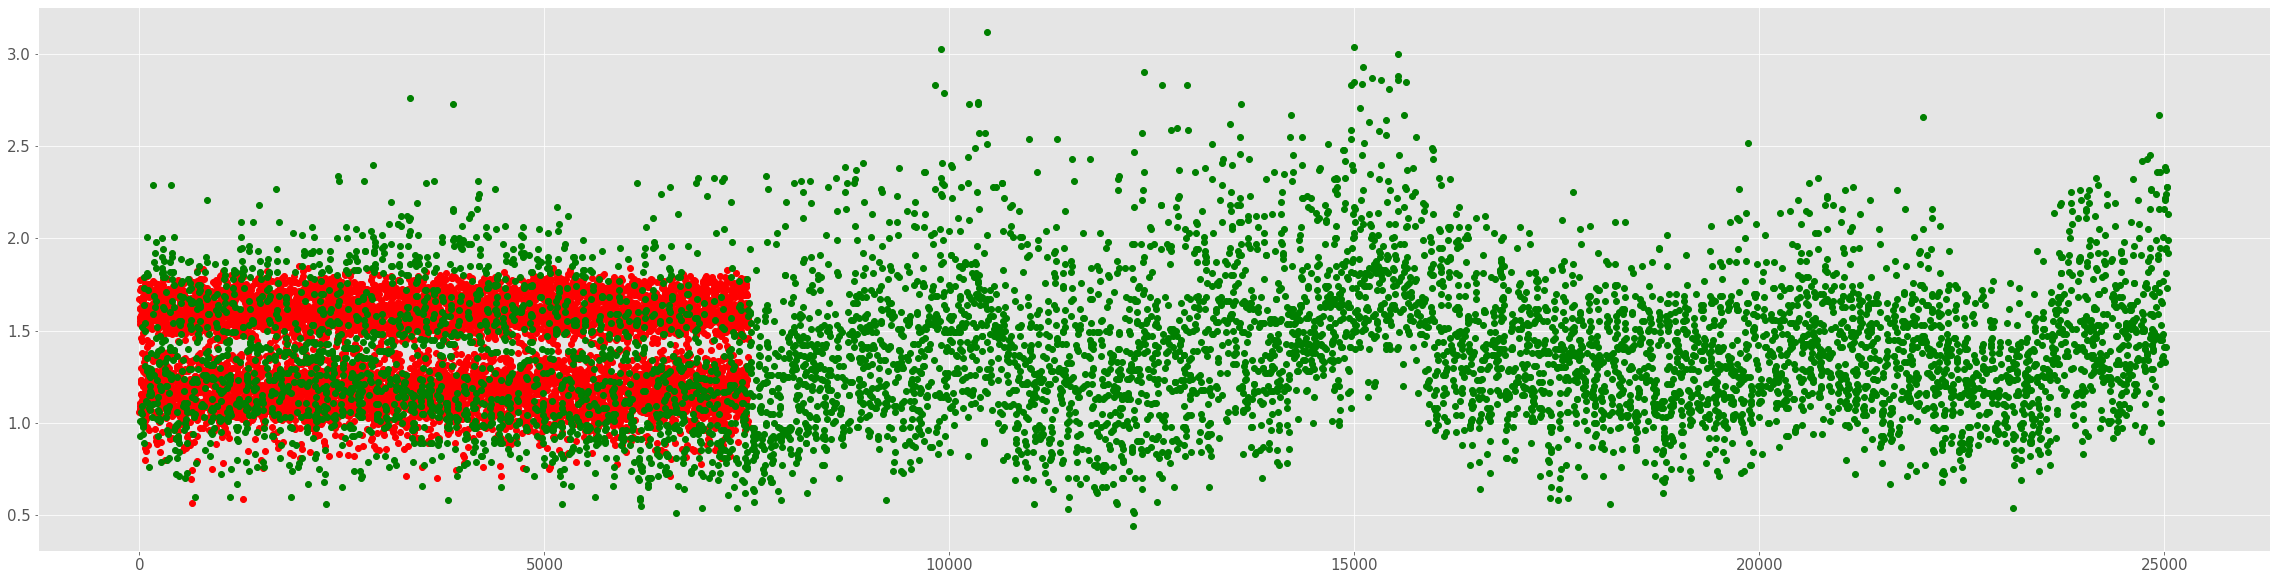


 ANN:
explained_variance:  0.4481
r2:  0.4477
MAE:  0.2168
MSE:  0.0792
RMSE:  0.2814
median_absolute_error:  0.1763
mean_squared_log_error:  0.013


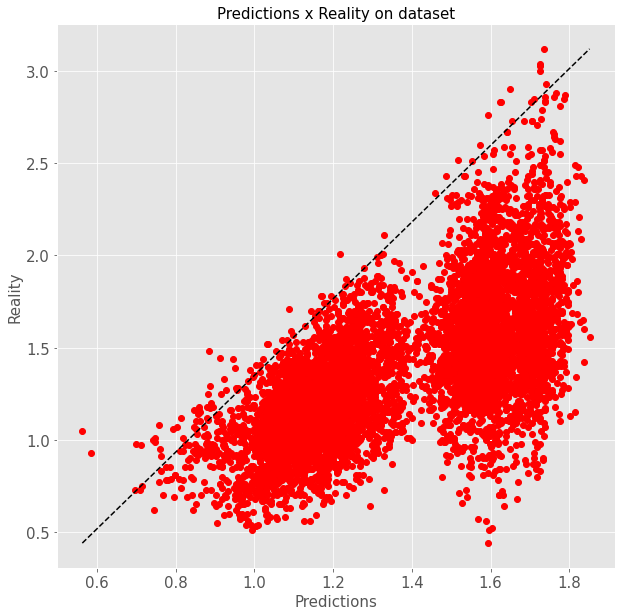

In [202]:
import matplotlib
from sklearn.metrics import r2_score, \
        explained_variance_score, mean_absolute_error, median_absolute_error, mean_squared_log_error, mean_squared_error

def regression_results(y_true_a, y_pred_a):
    all_positive = ((y_true_a >= 0).all() and (y_pred_a >= 0).all())
    # Regression metrics
    l_explained_variance=explained_variance_score(y_true_a, y_pred_a)
    l_mean_absolute_error=mean_absolute_error(y_true_a, y_pred_a)
    l_mean_squared=mean_squared_error(y_true_a, y_pred_a)
    l_median_absolute_error=median_absolute_error(y_true_a, y_pred_a)
    l_r2=r2_score(y_true_a, y_pred_a)


    print('explained_variance: ', round(l_explained_variance,4))
    print('r2: ', round(l_r2,4))
    print('MAE: ', round(l_mean_absolute_error,4))
    print('MSE: ', round(l_mean_squared,4))
    print('RMSE: ', round(np.sqrt(l_mean_squared),4))
    print('median_absolute_error: ', round(l_median_absolute_error,4))
    if (all_positive):
        l_mean_squared_log_error=mean_squared_log_error(y_true_a, y_pred_a)
        print('mean_squared_log_error: ', round(l_mean_squared_log_error,4))
def result_plot(y_test_b, y_pred_b, name):
    plt.figure(figsize=(40,10))
    plt.plot(y_pred_b, 'ro')
    plt.plot(y_test_b,' go')
    plt.show()
    print(f'\n {name}:')
    regression_results(y_test_b, y_pred_b)
    
    matplotlib.rc('xtick', labelsize=15)
    matplotlib.rc('ytick', labelsize=15)

    fig, ax = plt.subplots(figsize=(10, 10))

    plt.style.use('ggplot')
    plt.plot(y_pred_b, y_test_b, 'ro')
    plt.xlabel('Predictions', fontsize = 15)
    plt.ylabel('Reality', fontsize = 15)
    plt.title('Predictions x Reality on dataset', fontsize = 15)
    ax.plot([y_pred_b.min(), y_pred_b.max()], [y_test_b.min(), y_test_b.max()], 'k--')
    plt.show()

result_plot(y_test, y_predicted, 'ANN')